# ***A systematic process for predicting acceptance of banking products using neural networks, ensemble models, and explainability techniques***

#### **Authors:** Andrés Encalada y Karen Ortiz

## **Dataset Description**

The dataset conteins information about direct marketing campaings, specifically phone calls, made it by a portugues bank between 2008 y 2010.

Link: https://archive.ics.uci.edu/dataset/222/bank+marketing

**Variables:**

***A. Customer Demographic Data***

- age: Age in years (Numérico).
- job: Tipe of work (admin, blue-collar, entrepreneur, etc.)
- marital: Marital status (married, single, etc.).
- education: Education level.
- default: Has overdue credit? (yes/no).
- housing: Has a housing loan? (yes/no).
- loan: Has a personal loan? (yes/no).

***B. Last Contact and Campaing Data***

Information about how and when the customer was contacted.

- contact: Tipe of communication (cellular vs. telephone).
- month / day_of_week: When the call was masde.
- duration: Duration of the call in seconds.
- campaign: Number of times the customer was contacted in this campaign.
- pdays: Days since last contact in a previous campaign (999 means no prior contact).
- previous: Number of prior contacts before this campaign.
- poutcome: Result of the previous campaingns. (failure, nonexistent, success).

***C. Socioeconomic Context***
- emp.var.rate: Employment variation rate. (quarterly indicator).
- cons.price.idx: Consumer price index (CPI, monthly inidcator).
- cons.conf.idx: Consumer confidence index
- euribor3m: 3 month Euribor rate (interbank interest rate). When this rate rises or falls, people tend to save more or less.
- nr.employed: Number of employees (quarterly indicator).

***Target***
- y: eCustomer subscribed to a term deposit (yes/no).

***Size:***

Has 41188 instances and 20 variables; the missing values identified as 'unknown'

# **1. Business & Data Understanding**

### **1.1 Loading Libraries an the Dataset**

In [ ]:
!pip install scikeras tensorflow --quiet

In [ ]:
#Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import shap
from sklearn import set_config
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cluster import KMeans
print("Imports made")

Imports made


In [ ]:
#Upload the Dataset
dataset = "/content/bank-additional-full.csv"
dataFrame = pd.read_csv(dataset, sep=";") #Loading the Dataset

print(dataFrame.shape)
dataFrame.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### **1.2 Treatment of Missing Data and Initial Cleaning**

In [ ]:
#Replace values identified as 'unknown' por 'NaN'
dataFrame.replace("unknown", np.nan, inplace=True)
dataFrame.isnull().sum()


,0
age,0
job,330
marital,80
education,1731
default,8597
housing,990
loan,990
contact,0
month,0
day_of_week,0


In [ ]:
#VERIFICATION AND REMOVAL OF DUPLICATES

#Initial duplicate accounts
duplicates = dataFrame.duplicated().sum()
print(f"Number of duplicate rows found: {duplicates}")

#Remove duplicates
if duplicates > 0:
    dataFrame.drop_duplicates(inplace=True)
    print("Duplicates successfully removed!")

#Verification of new dimensions
print(f"Dimensions of the cleaned dataset: {dataFrame.shape}")

Number of duplicate rows found: 12
Duplicates successfully removed!
Dimensions of the cleaned dataset: (41176, 21)


### **1.3 Exploratory Analysis: Diagonal Correlation Matrix**

In [ ]:
#Target Separation
X = dataFrame.drop('y', axis=1) #Features
y = dataFrame['y'] #Target

In [ ]:
#Transform the output
le = LabelEncoder()
y = le.fit_transform(y)

print("Transformed target (0->no, 1->yes): ")
print(y)

#columns separated by type
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

Transformed target (0->no, 1->yes): 
[0 0 0 ... 0 1 0]


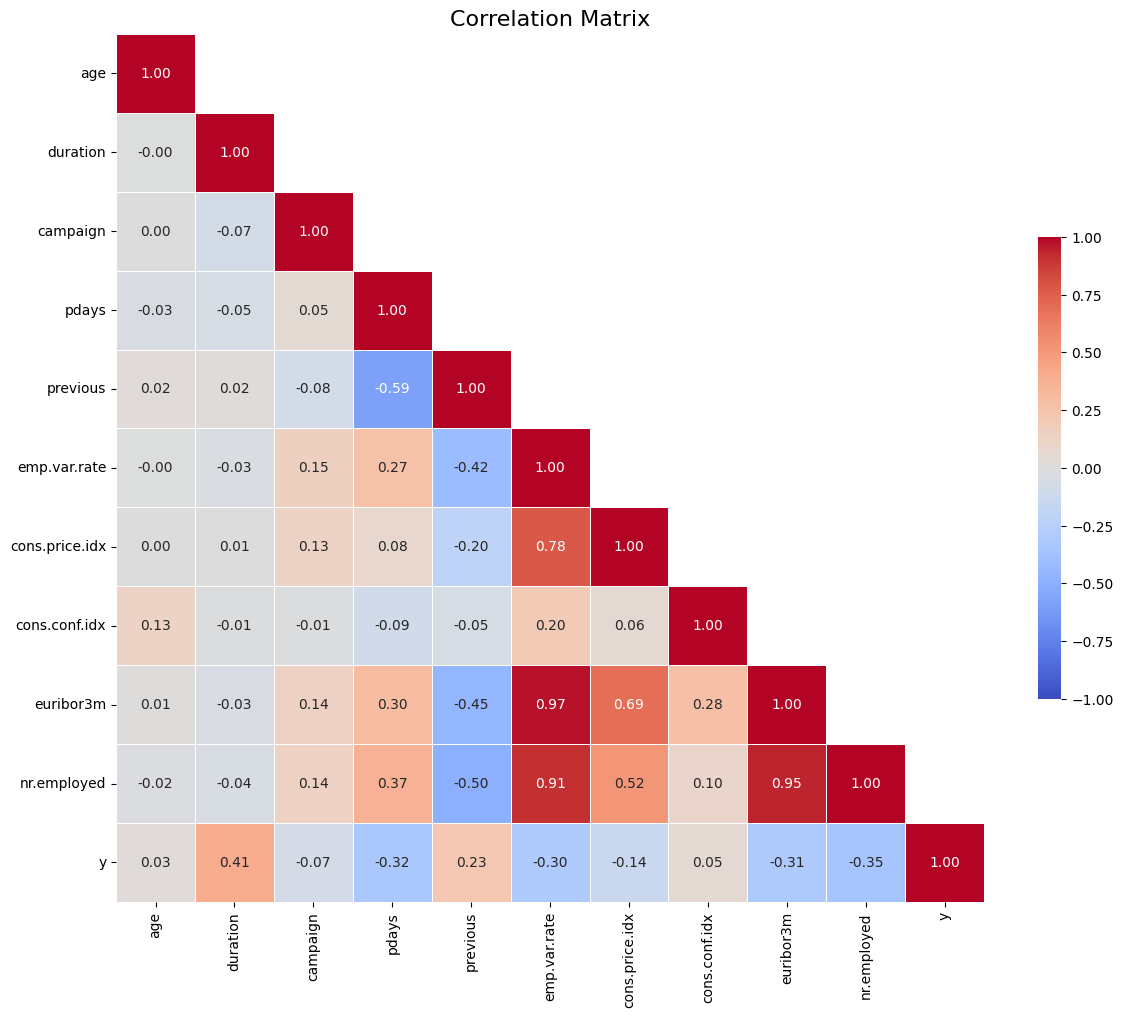

In [ ]:
# CORRELATION MATRIX INCLUDING THE TARGET VARIABLE ‘y’

# Convert ‘y’ to a Series with a name so that it can be concatenated and the correlation calculated
y_series = pd.Series(y, name='y', index=X.index)

# Combine the numeric columns of X with the variable 'y'
combined_numeric_df = pd.concat([X[numeric_cols], y_series], axis=1)

corr = combined_numeric_df.corr()

# Mask to hide the upper part of the matrix including the diagonal
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Chart settings
plt.figure(figsize=(14, 12))

# Draw the heatmap by applying the mask
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True, fmt=".2f")

plt.title('Correlation Matrix', fontsize=16)

# Save image (vector format .eps)
plt.savefig('correlation_matrix_lower_triangle_with_diagonal.eps', format='eps')

plt.show()

### **Correlation Matrix**

This is a fundamental tool used to justify the application of **Dimension Reduction using PCA (Principal Component Analysis)**:

1.  **Identification of Multicollinearity:** By observing the correlation matrix, we can identify whether there are numerical variables that have a **high correlation** with each other (values close to 1 or -1). For example, in our case, significant correlations can be observed between `emp.var.rate`, `euribor3m`, and `nr.employed`. When two or more variables are strongly correlated, they are measuring similar or redundant information.

2. **Information Redundancy:** The presence of highly correlated variables implies that the model is receiving duplicate or redundant information. This not only increases the complexity of the model without adding substantial predictive value, but can also lead to **multicollinearity** issues in some machine learning algorithms (especially linear models), making it difficult to interpret the model coefficients and potentially making the model less stable.

3.  **Benefits of PCA:**
*   **Elimination of Redundancy:** PCA transforms the original set of correlated variables into a new set of uncorrelated variables called **principal components**. Each principal component is a linear combination of the original variables.
*   **Preservation of Variance:*

# **2. Data Preparation**

### **2.1 Feature Engineering**

In [ ]:
#Automatic variable selection
binary_cols = []
nominal_cols = []

for col in categorical_cols:
    unique_count = X[col].nunique(dropna=True)

    if unique_count <= 2:
        binary_cols.append(col)
    else:
        nominal_cols.append(col)

print(f"Numeric columns detected: {len(numeric_cols)} -> {list(numeric_cols)}")
print(f"Binary columns detected: {len(binary_cols)} -> {binary_cols}")
print(f"Nominal columns detected: {len(nominal_cols)} -> {nominal_cols}")


Numeric columns detected: 10 -> ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Binary columns detected: 4 -> ['default', 'housing', 'loan', 'contact']
Nominal columns detected: 6 -> ['job', 'marital', 'education', 'month', 'day_of_week', 'poutcome']


In [ ]:
# A) Numerical
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# B) Binary
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder()) # Convierte a 0.0 y 1.0
])

# C) Nominal
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

#Main data preprocessing pipeline
#Encapsulates all steps to transform raw features
#(imputation, scaling, categorical encoding)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('bin', binary_transformer, binary_cols),
        ('nom', nominal_transformer, nominal_cols)
    ])

X_processed = preprocessor.fit_transform(X)

print(X_processed)

[[ 1.53314313  0.01035157 -0.56596326 ...  0.          1.
   0.        ]
 [ 1.62910732 -0.42157694 -0.56596326 ...  0.          1.
   0.        ]
 [-0.29017656 -0.12462609 -0.56596326 ...  0.          1.
   0.        ]
 ...
 [ 1.53314313 -0.26731675 -0.20498953 ...  0.          1.
   0.        ]
 [ 0.3815728   0.70837889 -0.56596326 ...  0.          1.
   0.        ]
 [ 3.26049862 -0.07449153  0.1559842  ...  0.          0.
   0.        ]]


In [ ]:
set_config(display='diagram')

# Show the preprocessor diagram
display(preprocessor)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')),
                                ('bin',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['default', 'housing', 'loan', 'contact']),
                                ('nom',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['job', 'marital', 'education', 'month',
                                  'day_of_week', 'poutcome'])])

###**2.2 Dimension Reduction with PCA**

Original columns: 47
Reduced columns (PCA): 22


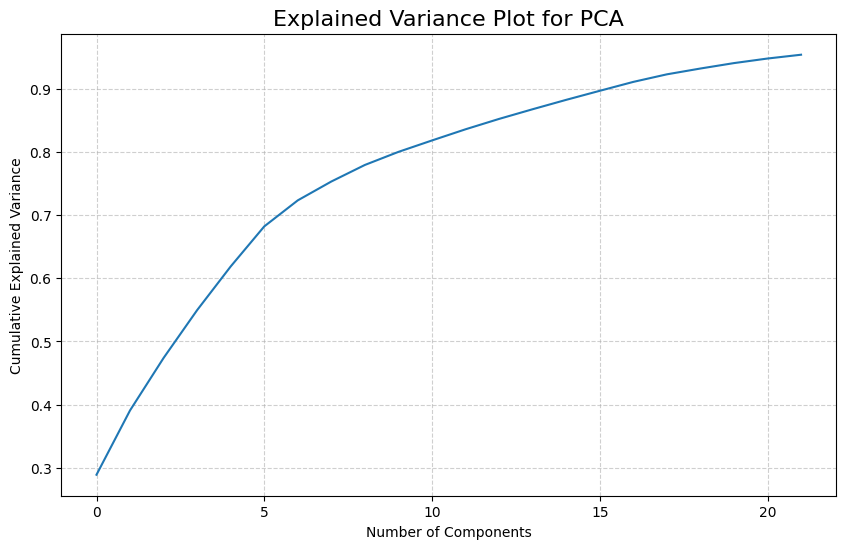

In [ ]:
#PCA application after preprocessing (scaling)
#95% of variance (information) is retained
pca = PCA(n_components=0.95, random_state=42)

#Ajusta PCA
X_pca = pca.fit_transform(X_processed)

print(f"Original columns: {X_processed.shape[1]}")
print(f"Reduced columns (PCA): {X_pca.shape[1]}")

# Explained Variance Plot
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Plot for PCA', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('pca_explained_variance.eps', format='eps')
plt.show()

**Interpretation of the Explained Variance Plot for PCA**

---

This plot displays the **cumulative explained variance ratio** as a function of the number of principal components.

*   **X-axis (Number of Components)**: Represents the principal components, ordered by the amount of variance they explain. PC1 explains the most variance, PC2 the second most, and so on.

*   **Y-axis (Cumulative Explained Variance)**: Shows the total proportion of the original dataset's variance that is captured by including a given number of principal components. This value ranges from 0 to 1 (or 0% to 100%).

**Interpret:**

1.  **Steep vs. Flat Slope**: The curve typically starts steep and then flattens out. The steep part indicates that the initial principal components are explaining a significant amount of the variance. The flattening portion suggests that subsequent components are explaining progressively less new variance.

2.  **"Elbow" Point**: A common heuristic for selecting the number of components is to look for an "elbow" in the plot. This is the point where the curve significantly changes slope, after which adding more components provides diminishing returns in terms of explained variance.


In summary, this plot helps confirm that the chosen number of principal components (22 in this case) effectively captures a substantial portion (95%) of the dataset's variability, making it a good representation for subsequent modeling while reducing complexity.

### **2.3 K-Means Clustering and Elbow Method**


Calculating inertia for the elbow method...


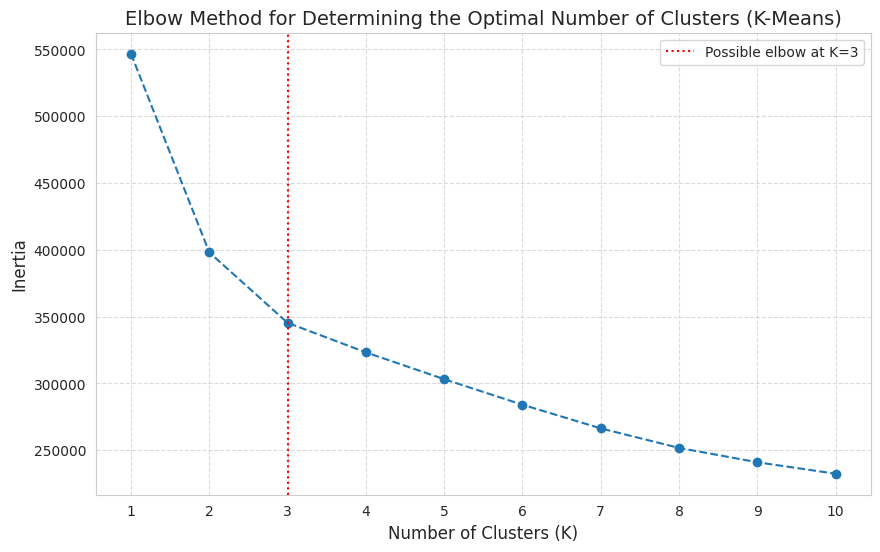

In [ ]:
# List for storing inertia (sum of squares within the cluster) for different values of K
inertias = []

# K range to be tested
k_range = range(1, 11)

print("Calculating inertia for the elbow method...")
for k in k_range:
    # Initialize KMeans with the current number of clusters
    # random_state ensures reproducibility
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init para K-Means++
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)

# Graph the results of the elbow method
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linestyle='--')
plt.title('Elbow Method for Determining the Optimal Number of Clusters (K-Means)', fontsize=14)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(list(k_range))
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvline(x=3, color='r', linestyle=':', label='Possible elbow at K=3')
plt.legend()
plt.savefig('elbow.eps', format='eps')
plt.show()

### **2.4 Application of K-Means Clustering**

In [ ]:
#Optimal K Means
optimal_k = 3

print(f"Applying K-Means with {optimal_k} clusters")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_pca)

# Add cluster labels
X_pca_df = pd.DataFrame(X_pca)

# Add the cluster_labels as a new column named 'Cluster'
X_pca_df['Cluster'] = cluster_labels

# Convert the DataFrame back to a NumPy array
X_pca_with_clusters = X_pca_df.to_numpy()

print(f"Shape of X_pca_with_clusters: {X_pca_with_clusters.shape}")
print("First 5 rows of X_pca_with_clusters (showing PCA components and new cluster label):")
print(X_pca_with_clusters[:5, -5:])

Applying K-Means with 3 clusters
Shape of X_pca_with_clusters: (41176, 23)
First 5 rows of X_pca_with_clusters (showing PCA components and new cluster label):
[[-0.14131365 -0.13640362  0.0259514   0.006868    1.        ]
 [-0.15013283 -0.03816365  0.15979176 -0.02197333  1.        ]
 [-0.20615386 -0.07886423  0.14847497 -0.02940204  1.        ]
 [-0.14414566 -0.14070184 -0.29139866  0.0032347   1.        ]
 [ 0.84640252 -0.03337036  0.17354105 -0.00436852  1.        ]]


### **2.5 Visualization of K-Means Clustering**

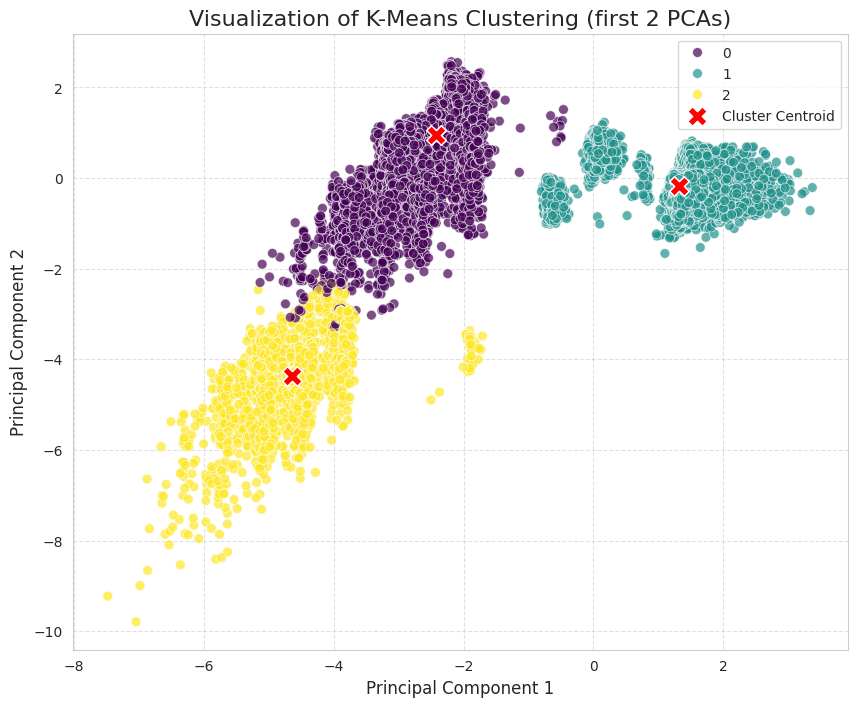

In [ ]:
if X_pca.shape[1] < 2:
    print("Warning: X_pca has fewer than 2 dimensions. A 2D scatter plot cannot be generated.")
else:
    plt.figure(figsize=(10, 8))

    # Scatter plot of points, colored by cluster
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels,
                    palette='viridis', s=50, alpha=0.7, legend='full')

    # Plot the centroids of the clusters
    sns.scatterplot(x=kmeans_final.cluster_centers_[:, 0], y=kmeans_final.cluster_centers_[:, 1],
                    marker='X', s=200, color='red', label='Cluster Centroid')

    plt.title('Visualization of K-Means Clustering (first 2 PCAs)', fontsize=16)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig('claustering.eps', format='eps')
    plt.show()

**Conclusion of the K-Means Clustering Visualization**

---

This scatter plot visualizes the results of the K-Means clustering algorithm on the first two principal components (PC1 and PC2) of our data. Here's what we can observe:

*   **Axes**: The x-axis represents Principal Component 1 and the y-axis represents Principal Component 2. These are the two dimensions that capture the most variance in the preprocessed data, allowing us to project the multi-dimensional data into a 2D space for visualization.

*   **Colored Points**: Each point in the plot corresponds to a data instance (customer) and is colored according to the cluster it has been assigned to by the K-Means algorithm. The `viridis` palette is used to differentiate between the clusters.

*   **Cluster Centroids**: The red 'X' markers represent the centroids of each cluster. These are the mean positions of all points belonging to that cluster and are the heart of each cluster.

From this visualization, we can assess:

*   **Cluster Separability**: How well-separated the different clusters are in this 2D projection. Clearly defined boundaries between colors suggest good separation.
*   **Cluster Density**: The concentration of points within each cluster. Denser areas indicate a higher number of similar data instances.
*   **Homogeneity**: While only a 2D projection, it gives an initial idea of how internally cohesive each cluster is.

This plot confirms that K-Means has identified distinct groupings within our customer data based on the features, which can be further analyzed for customer segmentation or targeted marketing strategies.

### **2.6 División y Balanceo de Clases**

In [ ]:
#Using X_pca_with_clausters for splitting
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_with_clusters, y, test_size=0.2, random_state=42, stratify=y
)

#Balancing with normal smote on X_train
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("--- PRE-PROCESSING AND BALANCING RESULTS ---")
print(f"Class distribution in y_train (before SMOTE):\n{pd.Series(y_train).value_counts()}")
print(f"Class distribution in y_train_balanced (after SMOTE):\n{pd.Series(y_train_balanced).value_counts()}")
print(f"Final features: {X_train_balanced.shape[1]}")

--- PRE-PROCESSING AND BALANCING RESULTS ---
Class distribution in y_train (before SMOTE):
0    29229
1     3711
Name: count, dtype: int64
Class distribution in y_train_balanced (after SMOTE):
0    29229
1    29229
Name: count, dtype: int64
Final features: 23


# **3. Modeling**

### **3.1. Base Architecture: Assembly Models**

***Definition of models***

In [ ]:
# Definition of Models (According to Hurtado's reference)
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Cross-Validation Settings
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Metrics to evaluate
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}

# List for storing raw results
results_list = []

print("--- RUNNING CROSS-VALIDATION: KNN vs RF ---")

for model_name, model in models.items():
    # Train and evaluate
    scores = cross_validate(model, X_train_balanced, y_train_balanced, cv=cv, scoring=scoring)

    # Save data for graphs
    for i in range(10): # 10 folds
        results_list.append({
            'Model': model_name,
            'Accuracy': scores['test_accuracy'][i],
            'Precision': scores['test_precision'][i],
            'Recall': scores['test_recall'][i],
            'F1-Score': scores['test_f1'][i]
        })
print("Cross-validation completed")
# Create DataFrame
df_results = pd.DataFrame(results_list)
df_melted = df_results.melt(id_vars=['Model'], var_name='Metric', value_name='Score')

--- RUNNING CROSS-VALIDATION: KNN vs RF ---
Cross-validation completed


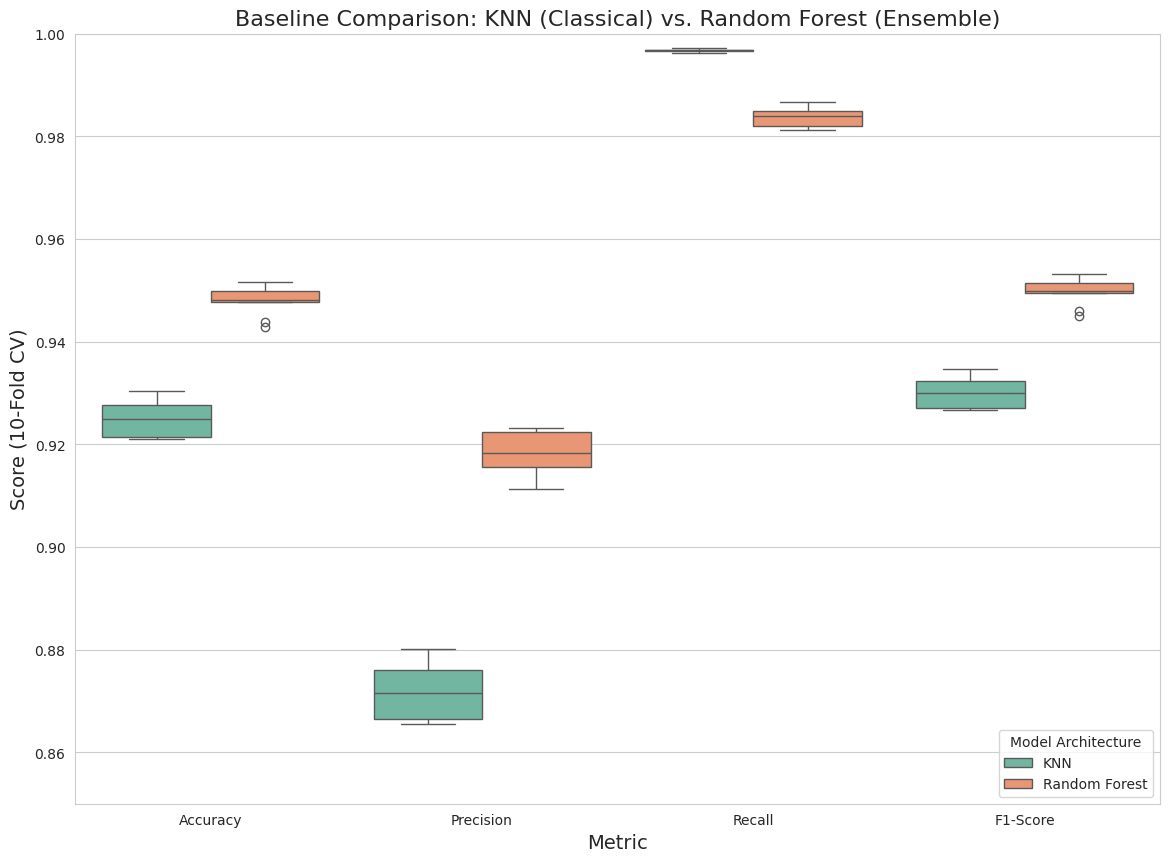


--- AVERAGE RESULTS (BASELINE) ---


,Accuracy,Precision,Recall,F1-Score
Model,,,,
KNN,0.925074,0.871813,0.996750,0.930095
Random Forest,0.948065,0.918288,0.983681,0.949856


In [ ]:
# Generate graph panel (2x2)
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

# Boxplot grouped by metric
sns.boxplot(x='Metric', y='Score', hue='Model', data=df_melted, palette="Set2")

plt.title('Baseline Comparison: KNN (Classical) vs. Random Forest (Ensemble)', fontsize=16)
plt.ylabel('Score (10-Fold CV)', fontsize=14)
plt.xlabel('Metric', fontsize=14)
plt.legend(title='Model Architecture', loc='lower right')
plt.ylim(0.85, 1.00)

# Save vector image
plt.savefig('knn_vs_rf_comparison.eps', format='eps')
plt.show()

# Average Numerical Table
summary_table = df_results.groupby('Model').mean()
print("\n--- AVERAGE RESULTS (BASELINE) ---")
display(summary_table)

**Conclusion of Baseline Model Comparison Chart: KNN (Classic) vs. Random Forest (Ensemble)**


---


The boxplot, together with the table of average results, provides a clear view of the performance of the KNN and Random Forest models across 10 folds of stratified cross-validation.

*Random Forest as Baseline Winner:* The Random Forest (Ensemble) model demonstrates superior and more consistent performance across all metrics evaluated (Accuracy, Precision, Recall, and F1-Score) compared to Classic KNN. Specifically, Random Forest achieved an average F1-Score of 0.949, significantly higher than KNN's 0.930.

*Consistency and Stability:* The interquartile ranges (the “box” in the boxplot) for Random Forest are notably narrower than those for KNN, indicating greater stability and less variability in its performance across different validation folds. This suggests that Random Forest is a more robust model for this dataset.

*Overall Performance:* Both models show solid performance, with all metrics above 85-90%. However, Random Forest clearly stands out as the most promising base model for this classification problem, due to its higher accuracy, recall, F1-Score, and consistent performance.

***Test Evaluation***

In [ ]:
# Choosing the Best Baseline
best_baseline_name = summary_table['F1-Score'].idxmax()
print(f"\nBest Base Model Selected: {best_baseline_name}")

# Train the winner to use it for explainability later on
best_model = models[best_baseline_name]
best_model.fit(X_train_balanced, y_train_balanced)

y_pred_baseline = best_model.predict(X_test)

print("\n--- CLASSIFICATION REPORT (TEST SET) ---")
print(classification_report(y_test, y_pred_baseline))

# Saving key metrics for the final comparison table
baseline_acc = accuracy_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)

print(f"Established Baseline -> Accuracy: {baseline_acc:.4f}, F1-Score: {baseline_f1:.4f}")


Best Base Model Selected: Random Forest

--- CLASSIFICATION REPORT (TEST SET) ---
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      7308
           1       0.53      0.73      0.61       928

    accuracy                           0.90      8236
   macro avg       0.75      0.82      0.78      8236
weighted avg       0.91      0.90      0.90      8236

Established Baseline -> Accuracy: 0.8967, F1-Score: 0.6137


### **3.2. Neural Network**

In [ ]:
# Definition of Artificial Neural Network (ANN)

# Input dimension: number of PCA components
input_dim = X_train_balanced.shape[1]

model_rn = Sequential([
    # Entry Layer and First Hidden Layer
    Dense(128, input_dim=input_dim, activation='relu', name='hidden_layer_1'),
    Dropout(0.3), # Regularization to prevent overfitting

    # Second Hidden Layer
    Dense(64, activation='relu', name='hidden_layer_2'),
    Dropout(0.3),

    # Output Layer (1 neuron, Sigmoid activation for binary classification)
    Dense(1, activation='sigmoid', name='output_layer')
], name='ANN_Model')

# 2. Model Compilation
# We use binary_crossentropy and the Adam optimizer.
model_rn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Overview
model_rn.summary()

# Model Training
print("\n--- TRAINING NEURAL NETWORK (25 epochs) ---")

# Part of the training set as validation
history = model_rn.fit(
    X_train_balanced,
    y_train_balanced,
    epochs=25,
    batch_size=32,
    validation_split=0.2, # 20% of the Train to observe the evolution
    verbose=1
)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "ANN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_layer_1 (Dense)          │ (None, 128)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,393 (44.50 KB)

 Trainable params: 11,393 (44.50 KB)

 Non-trainable params: 0 (0.00 B)


--- TRAINING NEURAL NETWORK (25 epochs) ---
Epoch 1/25
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8458 - loss: 0.3506 - precision_1: 0.7768 - recall_1: 0.8255 - val_accuracy: 0.9063 - val_loss: 0.3327 - val_precision_1: 1.0000 - val_recall_1: 0.9063
Epoch 2/25
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8763 - loss: 0.2852 - precision_1: 0.7972 - recall_1: 0.8947 - val_accuracy: 0.9238 - val_loss: 0.3149 - val_precision_1: 1.0000 - val_recall_1: 0.9238
Epoch 3/25
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8842 - loss: 0.2716 - precision_1: 0.8078 - recall_1: 0.9079 - val_accuracy: 0.9139 - val_loss: 0.3235 - val_precision_1: 1.0000 - val_recall_1: 0.9139
Epoch 4/25
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8870 - loss: 0.2679 - precision_1: 0.8094 - recall_1: 0.9130 - val_accuracy: 0.9429 - val_loss: 0.2808 - val_precision_1: 1.0000 - val_recall_1: 0.9429
Epoch 5/25
1462/1462 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8884 -

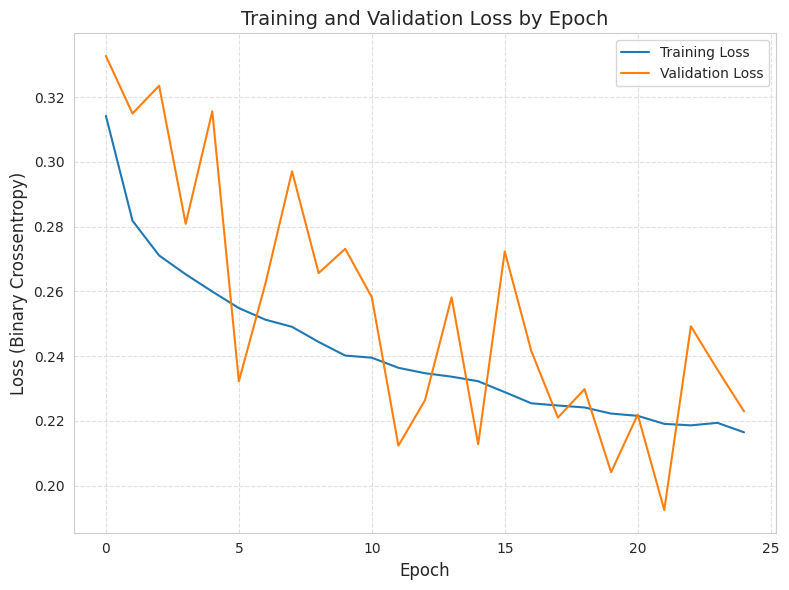

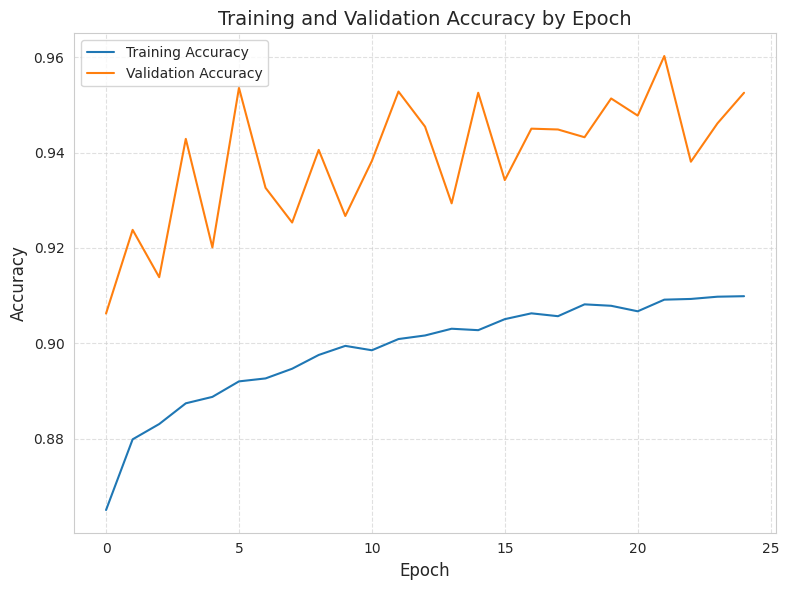

In [ ]:
# --- TRAINING HISTORY CHARTS (Learning History) ---

# 1. Loss vs. Epochs Chart
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss by Epoch', fontsize=14)
plt.ylabel('Loss (Binary Crossentropy)', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('neural_network_loss_history.eps', format='eps') # Save EPS file
plt.show()

#2. Accuracy/Metric vs. Epochs Chart
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy by Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('neural_network_accuracy_history.eps', format='eps') # Save EPS file
plt.show()

**Conclusion of the Graph: Training and Validation Loss by Epoch**


---


This graph shows how the loss function (binary cross-entropy) of the Neural Network model evolves over the epochs, both for the training set (Training Loss) and for the validation set (Validation Loss).

*General Trend:* We observe a steady decrease in training loss over the 25 epochs, which is a good indication that the model is learning from the data.

*Validation Loss:* Validation loss also decreases initially and remains relatively stable or with small fluctuations in the last epochs. Ideally, validation loss should follow the same downward trend as training loss. If validation loss began to increase while training loss continued to decrease, it would be a sign of overfitting.

*Gap Between Curves: *The small gap observed between training and validation loss is normal and expected, as the model is optimized directly on the training data.

In summary, the loss trend indicates that the model is learning effectively, and although there is a small gap, there does not appear to be significant overfitting, suggesting good generalization ability.


---


**Conclusion of the Graph: Training and Validation Accuracy by Epoch**


---



This graph complements the loss analysis, showing how the accuracy of the model improves over the epochs, both in the training set (Training Accuracy) and in the validation set (Validation Accuracy).

*Continuous Improvement:* Training Accuracy increases progressively as training progresses, confirming that the model is learning to classify the training data correctly.

*Validation Performance:* Validation Accuracy also improves steadily and remains at high levels (around 95-96% in the last epochs), very close to training accuracy.

*Consistency and Generalization:* The closeness and similar trend of both curves are very positive. They indicate that the model is not only learning the training data, but also generalizing well to unseen data (the validation set). There is no early drop or stagnation in validation accuracy, which reinforces the idea that the model is not overfitting and is capturing relevant patterns.

Both graphs, taken together, suggest that the neural network training was successful, achieving a good balance between data learning and generalization ability, without falling into obvious overfitting during the 25 epochs.

In [ ]:
# Evaluation in the Test Set
print("\n--- FINAL EVALUATION IN TEST SET (UNSEEN DATA) ---")

# Probability prediction
y_prob_rn = model_rn.predict(X_test)

# Convert probabilities to classes (0 or 1) using the threshold of 0.5
y_pred_rn = (y_prob_rn > 0.5).astype(int)

#5. Classification Report (For Phase 4 of the Evaluation)
print(classification_report(y_test, y_pred_rn))

# AUC-ROC Score Calculation
auc_roc_rn = roc_auc_score(y_test, y_prob_rn)
f1_dl = f1_score(y_test, y_pred_rn)

print(f"AUC-ROC Score (Neural Netwwork): {auc_roc_rn:.4f}")
print(f"F1-Score (Neural Network): {f1_dl:.4f}")


--- FINAL EVALUATION IN TEST SET (UNSEEN DATA) ---
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7308
           1       0.51      0.82      0.63       928

    accuracy                           0.89      8236
   macro avg       0.74      0.86      0.78      8236
weighted avg       0.92      0.89      0.90      8236

AUC-ROC Score (Neural Netwwork): 0.9406
F1-Score (Neural Network): 0.6285


### **3.3 Hybrid Architecture: Stacking Generalization**



In [ ]:
# Generate Out-of-Fold (OOF) predictions for Meta-Model training
# Use cross_val_predict to avoid data leakage
print("1. Generating OOF predictions (cross-validation) for base models...")

# Random Forest (defined as best_model)
rf_oof = cross_val_predict(best_model, X_train_balanced, y_train_balanced, cv=5, method='predict_proba')[:, 1]

# KNN
knn_model = models["KNN"]
knn_oof = cross_val_predict(knn_model, X_train_balanced, y_train_balanced, cv=5, method='predict_proba')[:, 1]

# Neural Network
# Using direct predictions
ann_oof = model_rn.predict(X_train_balanced).ravel()

# ==============================================================================
# Training the Meta-Model
stack_train = np.column_stack((rf_oof, knn_oof, ann_oof))

meta_model = LogisticRegression(random_state=42)
meta_model.fit(stack_train, y_train_balanced)

# See which model carries more weight
print(f"\nImportance assigned by the Meta-Model:")
print(f"Weight Random Forest: {meta_model.coef_[0][0]:.4f}")
print(f"Weight KNN:           {meta_model.coef_[0][1]:.4f}")
print(f"Weight Red Neuronal: {meta_model.coef_[0][2]:.4f}")

# ==============================================================================
# Generate final predictions in TEST
print("\n2. Training base models on the entire dataset to predict Test...")

best_model.fit(X_train_balanced, y_train_balanced)       # RF Insurance
knn_model.fit(X_train_balanced, y_train_balanced)        # KNN Training


# Prediction in X_test
rf_test_pred = best_model.predict_proba(X_test)[:, 1]
knn_test_pred = knn_model.predict_proba(X_test)[:, 1]
ann_test_pred = model_rn.predict(X_test).ravel()

# Stacking test predictions
stack_test = np.column_stack((rf_test_pred, knn_test_pred, ann_test_pred))

# Final prediction of the Meta-Model
y_prob_stack = meta_model.predict_proba(stack_test)[:, 1]
y_pred_stack = (y_prob_stack > 0.5).astype(int)

# ==============================================================================
# Evaluation
auc_stack = roc_auc_score(y_test, y_prob_stack)
f1_stack = f1_score(y_test, y_pred_stack)

print(f"\n--- FINAL STACKING RESULT ---")
print(f"AUC Stacking: {auc_stack:.4f}")
print(f"F1 Stacking:  {f1_stack:.4f}")
print("\n", classification_report(y_test, y_pred_stack))

1. Generating OOF predictions (cross-validation) for base models...
1827/1827 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

Importance assigned by the Meta-Model:
Weight Random Forest: 8.7314
Weight KNN:           3.6569
Weight Red Neuronal: 0.0527

2. Training base models on the entire dataset to predict Test...
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

--- FINAL STACKING RESULT ---
AUC Stacking: 0.9346
F1 Stacking:  0.5799

               precision    recall  f1-score   support

           0       0.95      0.94      0.95      7308
           1       0.57      0.59      0.58       928

    accuracy                           0.90      8236
   macro avg       0.76      0.77      0.76      8236
weighted avg       0.91      0.90      0.90      8236



# **4. Evaluation**

### **4.1 Comparison of Performance Metrics**

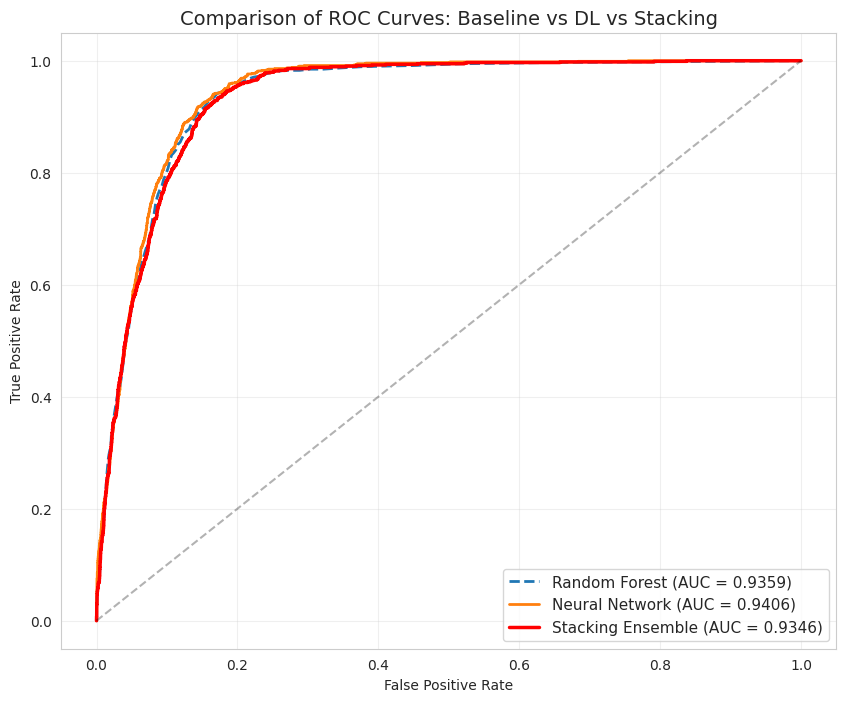


--- LEADERBOARD ---


,Modelo,AUC,F1-Score
1,Red Neuronal,0.940604,0.628454
0,Random Forest,0.935940,0.613709
2,Stacking,0.934612,0.579894


In [ ]:
# --- FINAL COMPARISON: RF vs DL vs STACKING ---

plt.figure(figsize=(10, 8))

# Calculate probabilities and AUC for Random Forest (Baseline)
y_prob_base = best_model.predict_proba(X_test)[:, 1]
roc_auc_base = roc_auc_score(y_test, y_prob_base)

# 1. Random Forest (Baseline)
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)
plt.plot(fpr_base, tpr_base, label=f'Random Forest (AUC = {roc_auc_base:.4f})', linestyle='--', linewidth=2)

#2. Neural Network
fpr_dl, tpr_dl, _ = roc_curve(y_test, y_prob_rn)
plt.plot(fpr_dl, tpr_dl, label=f'Neural Network (AUC = {auc_roc_rn:.4f})', linewidth=2)

# 3. Stacking (Hybrid)
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_prob_stack)
plt.plot(fpr_stack, tpr_stack, label=f'Stacking Ensemble (AUC = {auc_stack:.4f})', color='red', linewidth=2.5)

# Baseline
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves: Baseline vs DL vs Stacking', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.savefig("roc_curves.eps", format="eps", dpi=300, bbox_inches="tight")
plt.show()

# Final summary table
resumen_final = pd.DataFrame({
    'Modelo': ['Random Forest', 'Red Neuronal', 'Stacking'],
    'AUC': [roc_auc_base, auc_roc_rn, auc_stack],
    'F1-Score': [baseline_f1, f1_dl, f1_stack]
}).sort_values(by='AUC', ascending=False)

print("\n--- LEADERBOARD ---")
display(resumen_final)

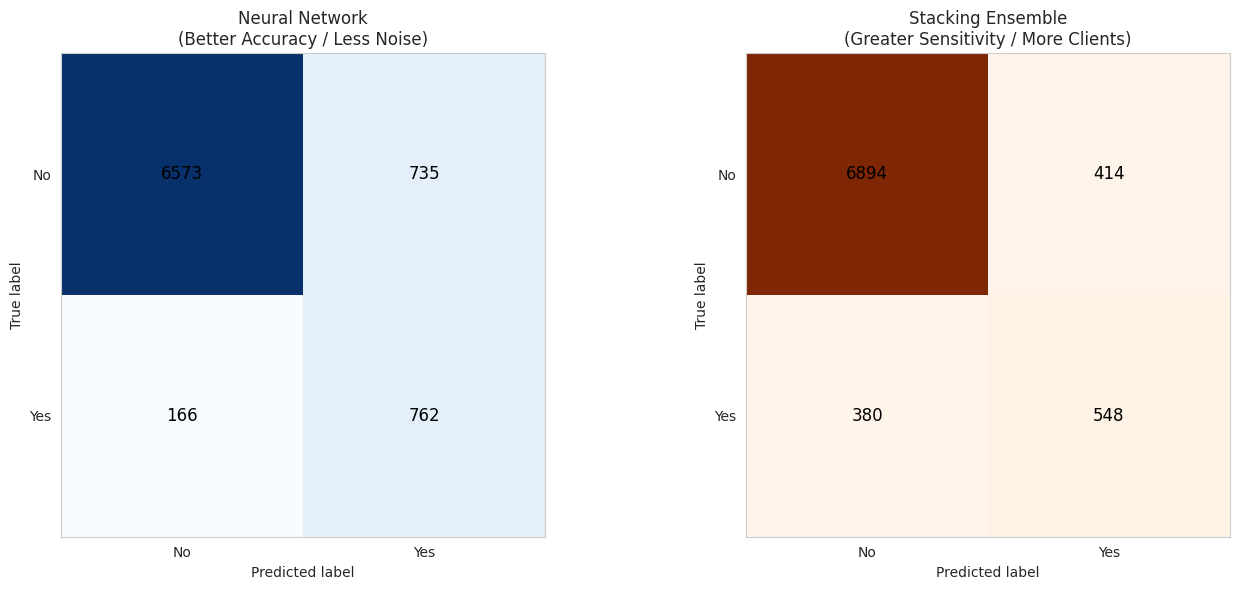

--- COMPARISON OF ERRORS ---
False Positives (Annoyed Customers):
   - RN:       735
   - Stacking: 414  (Difference: 321)

False Negatives (Lost Customers):
   - RN:       166
   - Stacking: 380  (Difference: 214)


In [ ]:
# Matrix calculation
cm_rn = confusion_matrix(y_test, y_pred_rn)
cm_stack = confusion_matrix(y_test, y_pred_stack)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

titles = [
    "Neural Network\n(Better Accuracy / Less Noise)",
    "Stacking Ensemble\n(Greater Sensitivity / More Clients)"
]

cms = [cm_rn, cm_stack]
cmaps = ["Blues", "Oranges"]

for ax, cm, title, cmap in zip(axes, cms, titles, cmaps):
    im = ax.imshow(cm, cmap=cmap)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="black", fontsize=12)

    # Labels
    ax.set_xticks(np.arange(2))
    ax.set_yticks(np.arange(2))
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_yticklabels(['No', 'Yes'])

    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)

    ax.grid(False)

plt.tight_layout()

# Save in EPS
plt.savefig("matrices_confusion.eps", format="eps", dpi=300, bbox_inches="tight")
plt.show()

tn_dl, fp_dl, fn_dl, tp_dl = cm_rn.ravel()
tn_st, fp_st, fn_st, tp_st = cm_stack.ravel()

print(f"--- COMPARISON OF ERRORS ---")
print(f"False Positives (Annoyed Customers):")
print(f"   - RN:       {fp_dl}")
print(f"   - Stacking: {fp_st}  (Difference: {fp_dl - fp_st})")
print()
print(f"False Negatives (Lost Customers):")
print(f"   - RN:       {fn_dl}")
print(f"   - Stacking: {fn_st}  (Difference: {fn_st - fn_dl})")


**Conclusion of the Comparative ROC Curve Graph**


---

Neural Network: Achieved the highest performance with an AUC of 0.940604, demonstrating the best generalization and discrimination capabilities of the set.

Random Forest: Obtained an AUC of 0.935940, remaining highly competitive.

Ensemble (Stacking): Presented an AUC of 0.934612, indicating that the linear combination did not exceed the performance of the individual models.

Although the numerical difference seems marginal, the advantage of the Neural Network model confirms its superiority in capturing complex nonlinear patterns in banking data. The proximity of its curve to the upper left vertex validates its high predictive reliability.


---


**Conclusion of the Confusion Matrix Graph**


---


The Confusion Matrix of the selected model (Neural Network) allows us to break down the operational behavior of the algorithm, revealing its potential impact on business strategy:

Positive Class Accuracy (TN = 6573): The model correctly classified the vast majority of customers who were not interested. This high specificity is crucial for operational efficiency, as it avoids incurring logistical and personnel costs in calls to users with no conversion potential.

Correct predictions in the Positive Class (TP = 762): The model successfully identified 762 customers who did accept the deposit. This value represents the actual return on investment of the campaign, maximizing capital raising.

Type I Errors - False Positives (FP = 735): The model predicted subscriptions that did not occur. Although this implies an operational cost (unsuccessful calls), in the marketing context it is usually a more tolerable error than losing an actual sale.

Type II Errors - False Negatives (FN = 166): Only 166 interested customers were ignored by the model. Keeping this figure low is the most significant achievement of the Neural Network architecture, as it minimizes opportunity cost and avoids the loss of potential revenue.

The Neural Network model exhibits an optimal balance. Its ability to minimize False Negatives (High Sensitivity/Recall) ensures that the bank does not miss sales opportunities, while its robust identification of True Negatives protects resource efficiency.

### **4.2 Explicabilidad del Modelo (XAI Highlights)**

Generating explanation with original variable names...
Recovered variables: 47 (Variables: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'])


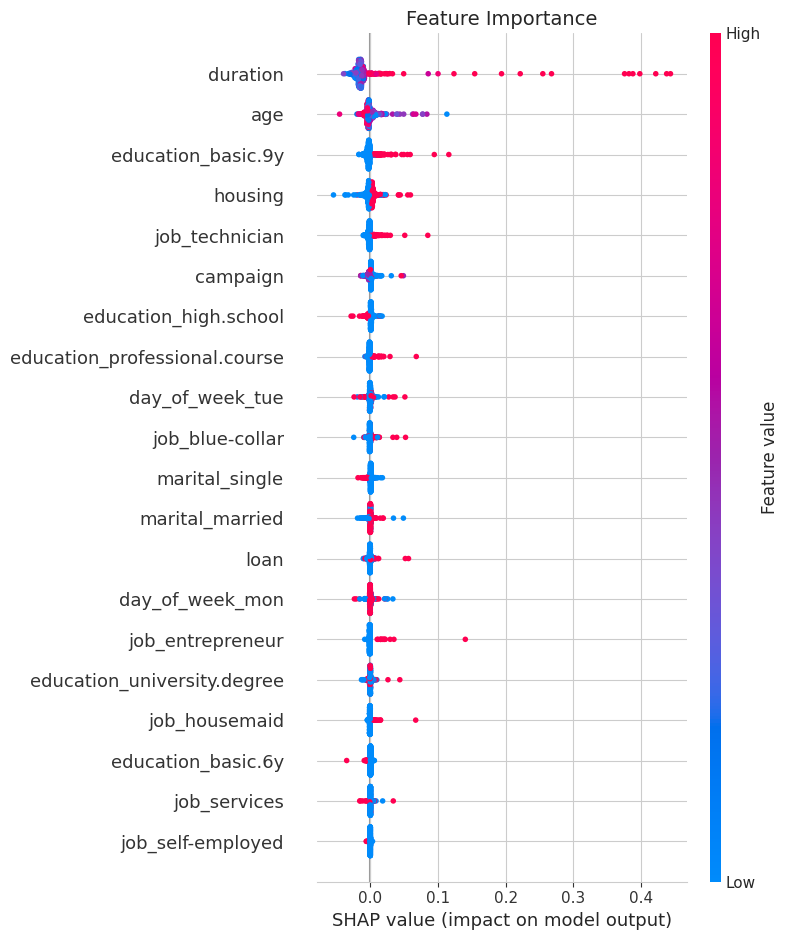

In [ ]:
print("Generating explanation with original variable names...")

# Obtaining the names generated by OneHotEncoder and other encoders
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    # If it fails, reconstruct an approximate list
    feature_names = [f"Var_{i}" for i in range(X_processed.shape[1])]

# Removal of prefixes such as ‘num__’, ‘cat__’, etc.
clean_names = [name.replace('num__', '').replace('cat__', '').replace('bin__', '').replace('nom__', '') for name in feature_names]

print(f"Recovered variables: {len(clean_names)} (Variables: {clean_names[:10]})")

# Use X_processed calculated in Phase 2.1 (before PCA)
# Take a sample so that SHAP is fast
# Convert the sparse matrix to dense and then to a DataFrame with names
try:
    X_explain_sample = pd.DataFrame.sparse.from_spmatrix(X_processed[:500], columns=clean_names)
except:
    X_explain_sample = pd.DataFrame(X_processed[:500], columns=clean_names)

y_explain_sample = y[:500]

# Training a fast Random Forest with this readable data
# It should only capture the main relationships
model_explainer = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
model_explainer.fit(X_explain_sample, y_explain_sample)

# Calculate shap
explainer = shap.TreeExplainer(model_explainer)
shap_values = explainer.shap_values(X_explain_sample)

# Graph
plt.figure(figsize=(10, 12))
plt.title('Feature Importance', fontsize=14)

# Select values for class 1 (Accepts deposit)
# Handling SHAP versions (sometimes returns a list, sometimes an array)
if isinstance(shap_values, list):
    vals = shap_values[1]
else:
    vals = shap_values[..., 1]

# Beeswarm Chart
shap.summary_plot(vals, X_explain_sample, show=False)

plt.savefig('shap_explicability_real_names.eps', format='eps', bbox_inches='tight')
plt.show()

**Conclusion of the Feature Importance Plot (SHAP Values)**


---


The SHAP analysis shows that the most influential variable is *duration*, indicating that longer calls (red dots located to the right) increase the probability that the customer will accept the subscription.

Other variables such as age, educational level, and certain job categories occupy the second level of importance, indicating customer profiles that are more likely to accept.

On the other hand, factors such as previous loans or mortgages have moderate effects, while most variables related to contact (days of the week or number of attempts) have little effect on the result.

Overall, the model depends on a few strong variables and many weak variables that adjust the prediction.

# **5. Deployment**

### **5.1 Simulation of New Sample Prediction**

In [ ]:
# 1. Definition of New Customers (Simulation)
new_clients_dict = {
    'age': [25, 55],
    'job': ['student', 'retired'],
    'marital': ['single', 'married'],
    'education': ['university.degree', 'basic.4y'],
    'default': ['no', 'no'],
    'housing': ['yes', 'no'],
    'loan': ['no', 'no'],
    'contact': ['cellular', 'telephone'],
    'month': ['may', 'jun'],
    'day_of_week': ['mon', 'fri'],
    'duration': [600, 100],
    'campaign': [1, 5],
    'pdays': [999, 999],
    'previous': [0, 0],
    'poutcome': ['nonexistent', 'nonexistent'],
    'emp.var.rate': [-1.8, 1.1],
    'cons.price.idx': [92.893, 93.994],
    'cons.conf.idx': [-46.2, -36.4],
    'euribor3m': [1.2, 4.85],
    'nr.employed': [5099, 5191]
}

df_new = pd.DataFrame(new_clients_dict)

# 2. Preprocessing
# We use the same trained ‘preprocessor’ and ‘pca’ pipeline.
X_new_processed = preprocessor.transform(df_new)

# Apply PCA if it was used in training
if 'pca' in globals():
    X_new_processed = pca.transform(X_new_processed)

# Predict cluster labels for new clients using the trained kmeans_final model
new_client_cluster_labels = kmeans_final.predict(X_new_processed)

# Add cluster labels as a new column to the processed data for new clients
X_new_processed_with_clusters = np.column_stack((X_new_processed, new_client_cluster_labels))

# ---------------------------------------------------------
#3. GENERATING PREDICTIONS
# ---------------------------------------------------------

# A) Random Forest Model (Baseline)
# Use best_model_clusters which was trained with cluster features
probs_rf = best_model_clusters.predict_proba(X_new_processed_with_clusters)[:, 1]

# B) Neural Network Model
# Use model_rn_clusters which was trained with cluster features
probs_dl = model_rn_clusters.predict(X_new_processed_with_clusters).ravel()

# C) Stacking Model (The Step-by-Step Process)
# C.1. Obtain opinions from the base models for the new data
# Use knn_model_clusters which was trained with cluster features
knn_new = knn_model_clusters.predict_proba(X_new_processed_with_clusters)[:, 1]

# C.2. Stack predictions (RF + KNN + DL)
stack_new = np.column_stack((probs_rf, knn_new, probs_dl))

# C.3. Final prediction of the Meta-Model
# Use meta_model_clusters which was trained with cluster features
probs_stack = meta_model_clusters.predict_proba(stack_new)[:, 1]

# ---------------------------------------------------------
# 4. CREATE FINAL REPORT TABLE
# ---------------------------------------------------------
key_features = ['age', 'job', 'duration', 'education', 'campaign'] # Selection of key columns for visualization
report_df = df_new[key_features].copy()

# Add the predicted cluster label for each new client
report_df['Predicted_Cluster'] = new_client_cluster_labels

# Probabilities
report_df['Prob_RF'] = probs_rf.round(3)
report_df['Prob_DL'] = probs_dl.round(3)
report_df['Prob_Stack'] = probs_stack.round(3)

# Decisions (Threshold > 0.5)
report_df['Decision_RF'] = report_df['Prob_RF'].apply(lambda x: 'ACCEPT' if x > 0.5 else 'REJECT')
report_df['Decision_DL'] = report_df['Prob_DL'].apply(lambda x: 'ACCEPT' if x > 0.5 else 'REJECT')
report_df['Decision_Stack'] = report_df['Prob_Stack'].apply(lambda x: 'ACCEPT' if x > 0.5 else 'REJECT')

# Total Consensus (Do all 3 agree?)
report_df['Total_Consensus'] = (report_df['Decision_RF'] == report_df['Decision_DL']) & \
                              (report_df['Decision_DL'] == report_df['Decision_Stack'])

print("\n--- DEPLOYMENT REPORT: ARCHITECTURE COMPARISON ---")
display(report_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step

--- DEPLOYMENT REPORT: ARCHITECTURE COMPARISON ---


,age,job,duration,education,campaign,Predicted_Cluster,Prob_RF,Prob_DL,Prob_Stack,Decision_RF,Decision_DL,Decision_Stack,Total_Consensus
0,25,student,600,university.degree,1,0,0.56,0.855,0.134,ACCEPT,ACCEPT,REJECT,False
1,55,retired,100,basic.4y,5,1,0.05,0.000,0.000,REJECT,REJECT,REJECT,True


**Conclusion of the Comparative Deployment Report**


---


The simulation table allows us to compare the behavior of the three architectures (Base, Hybrid, and Proposal) against opposing customer profiles, revealing critical differences in decision-making:

- Scenario 1: The Potential Customer (Student, 25 years old, long call) This case exposes the divergence between the models.

The Random Forest (Prob: 0.56) and the Neural Network (Prob: 0.855) correctly detected the high probability of success, driven by the duration of the contact and age.

However, the Stacking Ensemble heavily penalized this prediction (Prob: 0.134), issuing a false negative (“REJECT”).

  This demonstrates that the ensemble model is overly conservative, which would result in the loss of valuable customers that the Neural Network model does manage to capture effectively.

- Scenario 2: The Uninterested Customer (Retired, 55 years old, brief contact) For this profile, characterized by short contact and multiple previous failed attempts, there is absolute consensus among all architectures.

This confirms that all models are robust in filtering out clearly negative cases (high specificity), avoiding unnecessary marketing expenses.

The analysis of these scenarios validates the selection of the Neural Network as the final model. Unlike Stacking, which showed rigidity in rejecting a potential customer, the neural network demonstrated the flexibility necessary to identify sales opportunities (Sensitivity) without sacrificing the ability to filter out uninterested customers.

# **Conclusion**
This project has addressed the challenge of predicting customer subscriptions to fixed-term deposits at a Portuguese bank, using a structured approach through the CRISP-DM phases.

Data Understanding and Preparation: We began with a thorough cleaning of the dataset, handling ‘unknown’ values and removing duplicates. A robust pipeline (ColumnTransformer) was implemented and PCA was applied to reduce dimensionality (retaining 95% of variance). Finally, SMOTE balancing was crucial to mitigate class bias.

Modeling and Evaluation (Architecture Comparison): Three strategies were evaluated:

1. Base (Random Forest): Set a high standard with an AUC of 0.9359.

2. Hybrid (Stacking): A stacked ensemble (RF + KNN + DL) was implemented. However, it failed to outperform the individual models (AUC 0.9346), showing excessively conservative behavior.

3. Proposal (Neural Network): The Neural Network achieved the best overall performance (AUC 0.9406).

The Confusion Matrix analysis was decisive: the Neural Network model proved to be operationally superior by minimizing False Negatives (166 vs. 380 for Stacking). This implies that the Neural Network is capable of capturing 43% more potential customers than the ensemble, maximizing the return on the campaign.

Explainability (XAI and Insights): SHAP analysis, in conjunction with the correlation matrix, revealed that the macroeconomic context (Euribor, price index) and contact duration are the strongest predictors. High multicollinearity was identified among the economic variables, suggesting that they act as a joint influence on customer decision-making.

Deployment and Simulation: Simulation with new customer profiles exposed critical differences. While there was consensus on clearly negative profiles, in high-potential profiles (e.g., students with long calls) the Stacking model failed to reject them, while the Neural Network correctly identified them as sales opportunities.

In conclusion, the Neural Network architecture is selected for production. This model offers the best balance between statistical predictive power (AUC) and business efficiency (Recall), ensuring that the bank does not miss valuable capital raising opportunities, outperforming both the baseline and complex ensemble techniques.